In [4]:
import os
import requests, shutil, zipfile

# Define the COCO dataset URLs
coco_images_url = 'http://images.cocodataset.org/zips/train2017.zip'
coco_annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# Define download paths
data_dir = './coco2017/'
images_zip_path = os.path.join(data_dir, 'train2017.zip')
annotations_zip_path = os.path.join(data_dir, 'annotations_trainval2017.zip')

# Create directory to store dataset
os.makedirs(data_dir, exist_ok=True)

# Download images
if not os.path.exists(os.path.join(data_dir, 'train2017')):
    print("Downloading COCO train images...")
    r = requests.get(coco_images_url, stream=True)
    with open(images_zip_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    
    # Unzip images
    with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("COCO train images downloaded and extracted.")

# Download annotations
if not os.path.exists(os.path.join(data_dir, 'annotations')):
    print("Downloading COCO annotations...")
    r = requests.get(coco_annotations_url, stream=True)
    with open(annotations_zip_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    
    # Unzip annotations
    with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("COCO annotations downloaded and extracted.")


In [5]:
from pycocotools.coco import COCO

# Initialize COCO API
annotation_file = os.path.join(data_dir, 'annotations/instances_train2017.json')
coco = COCO(annotation_file)

# Get the category ID for "person"
person_category_id = coco.getCatIds(catNms=['person'])[0]

# Get all images containing people
person_image_ids = coco.getImgIds(catIds=[person_category_id])
print(f"Number of images containing people: {len(person_image_ids)}")


loading annotations into memory...
Done (t=9.22s)
creating index...
index created!
Number of images containing people: 64115


In [6]:
import cv2
import numpy as np

# Function to load and preprocess images along with bounding boxes
def load_and_preprocess_image_and_labels(coco, img_id, data_dir, img_size=(224, 224)):
    # Load image info and image file
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(data_dir, 'train2017', img_info['file_name'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    
    # Resize image to desired input size
    img = cv2.resize(img, img_size)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension

    # Get annotations (bounding boxes) for this image
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_category_id])
    anns = coco.loadAnns(ann_ids)
    
    # Convert bounding boxes to YOLO format (x_center, y_center, width, height) and normalize
    bbox_list = []
    img_width, img_height = img_info['width'], img_info['height']
    for ann in anns:
        bbox = ann['bbox']
        x_center = (bbox[0] + bbox[2] / 2) / img_width
        y_center = (bbox[1] + bbox[3] / 2) / img_height
        width = bbox[2] / img_width
        height = bbox[3] / img_height
        bbox_list.append([0, x_center, y_center, width, height])  # Class ID is 0 for 'person'
    
    return img, bbox_list


In [7]:
import numpy as np

# Define the maximum number of bounding boxes per image
MAX_BBOXES = 5  # Adjust based on your dataset characteristics

def pad_bboxes(bboxes, max_bboxes=MAX_BBOXES):
    """
    Pads or truncates the list of bounding boxes to max_bboxes.
    Each bounding box is a list of [class_id, x_center, y_center, width, height].
    """
    padded_bboxes = np.zeros((max_bboxes, 5))  # 5 elements per bbox (class_id, x_center, y_center, width, height)
    
    # Truncate if there are more than max_bboxes
    if len(bboxes) > max_bboxes:
        bboxes = bboxes[:max_bboxes]
    
    # Pad the remaining space with zeros
    for i, bbox in enumerate(bboxes):
        padded_bboxes[i] = bbox
    
    return padded_bboxes

# Function to flatten the bounding boxes
def flatten_bboxes(bboxes):
    """
    Flatten the list of bounding boxes to match the shape of the model output.
    Removes the class_id and flattens the bounding boxes.
    """
    # Remove the class_id (first element of each bounding box) and flatten the rest
    return bboxes[:, 1:].flatten()  # Keep only x_center, y_center, width, height

# Prepare dataset for YOLO (images and labels)
images = []
flattened_labels = []
for img_id in person_image_ids[:2000]:  # Limit to 2000 images for example
    img, bboxes = load_and_preprocess_image_and_labels(coco, img_id, data_dir)
    images.append(img)
    
    # Pad/truncate bounding boxes for each image
    padded_bboxes = pad_bboxes(bboxes)
    
    # Flatten the bounding boxes and add them to the flattened_labels list
    flattened_labels.append(flatten_bboxes(padded_bboxes))

# Convert to numpy arrays for easy batching
images = np.array(images)
flattened_labels = np.array(flattened_labels)

print(f"Shape of images: {images.shape}")
print(f"Shape of flattened labels: {flattened_labels.shape}")



Shape of images: (2000, 224, 224, 1)
Shape of flattened labels: (2000, 20)


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def yolo_fastest(num_classes, input_shape=(224, 224, 1), max_bboxes=5):
    inputs = layers.Input(shape=input_shape)

    # Layer 1: First Convolution + BatchNorm + ReLU
    x = layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    # Layer 2: MaxPooling
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3: Convolution + BatchNorm + ReLU
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Layer 4: MaxPooling
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 5: Convolution + BatchNorm + ReLU
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Layer 6: MaxPooling
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 7: Convolution + BatchNorm + ReLU
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Layer 8: MaxPooling
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 9: Convolution + BatchNorm + ReLU
    x = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Flattening bounding box predictions and class predictions
    x = layers.Flatten()(x)

    # Layer 10: Dense layer for bounding box prediction (4 values per box: x_center, y_center, width, height)
    bbox_output = layers.Dense(max_bboxes * 4, activation='linear')(x)  # For max_bboxes bounding boxes per image

    # Layer 11: Dense layer for binary class prediction (sigmoid for binary classification)
    class_output = layers.Dense(1, activation='sigmoid')(x)  # Use sigmoid for binary classification

    # Final model
    model = Model(inputs=inputs, outputs=[bbox_output, class_output])

    return model

# Define the number of classes (for person detection, it's just 1 class)
num_classes = 1
max_bboxes = 5  # Adjust this value as per your dataset (max number of bounding boxes per image)

# Create the YOLO-Fastest model
model = yolo_fastest(num_classes=num_classes, max_bboxes=max_bboxes)

# Compile the model with appropriate loss and metrics
model.compile(optimizer='adam',
              loss=['mean_squared_error', 'binary_crossentropy'],  # Use binary_crossentropy for class output
              metrics=[['mean_squared_error'], ['accuracy']])  # Accuracy for class prediction

# Assuming 'person' class (1 for person detection)
class_labels = np.ones((len(images), 1))  # Every image has the class 'person'


In [33]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras import layers, Model

# Define the YOLO-Fastest model with per-layer pruning
def yolo_fastest_pruned(num_classes, input_shape=(224, 224, 1), max_bboxes=5):
    inputs = layers.Input(shape=input_shape)

    # Apply pruning to each layer
    x = tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tfmot.sparsity.keras.prune_low_magnitude(
        layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))(x)
    x = layers.BatchNormalization()(x)

    # Flatten and Dense layers for output
    x = layers.Flatten()(x)
    bbox_output = layers.Dense(max_bboxes * 4, activation='linear')(x)  # Bounding box output
    class_output = layers.Dense(1, activation='sigmoid')(x)  # Binary class output

    # Create the pruned model
    model = Model(inputs=inputs, outputs=[bbox_output, class_output])

    return model

# Number of classes and bounding boxes
num_classes = 1
max_bboxes = 5

# Create the model
model = yolo_fastest_pruned(num_classes=num_classes, max_bboxes=max_bboxes)

# Define pruning schedule
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.50,
        final_sparsity=0.80,
        begin_step=0,
        end_step=1000
    )
}

# Apply pruning to the entire model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# Compile the model
pruned_model.compile(optimizer='adam',
                     loss=['mean_squared_error', 'binary_crossentropy'],
                     metrics=[['mean_squared_error'], ['accuracy']])

ValueError: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Conv2D.

In [12]:
# Train the model
history = model.fit(images, [flattened_labels, class_labels], epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 463ms/step - dense_6_loss: 6.2167 - dense_6_mean_squared_error: 6.2167 - dense_7_accuracy: 0.9490 - dense_7_loss: 0.1226 - loss: 6.3394 - val_dense_6_loss: 0.3274 - val_dense_6_mean_squared_error: 0.3271 - val_dense_7_accuracy: 1.0000 - val_dense_7_loss: 0.0479 - val_loss: 0.3745
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 449ms/step - dense_6_loss: 3.3453 - dense_6_mean_squared_error: 3.3453 - dense_7_accuracy: 0.9992 - dense_7_loss: 0.0029 - loss: 3.3483 - val_dense_6_loss: 0.4256 - val_dense_6_mean_squared_error: 0.4241 - val_dense_7_accuracy: 1.0000 - val_dense_7_loss: 0.0295 - val_loss: 0.4539
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - dense_6_loss: 1.4208 - dense_6_mean_squared_error: 1.4208 - dense_7_accuracy: 1.0000 - dense_7_loss: 3.6550e-04 - loss: 1.4211 - val_dense_6_loss: 0.4420 - val_dense_6_mean_squared_error: 0.4427 - val_dense_7_accuracy: 1.0000 - val_dense_7_loss: 0.0086 - val_loss: 0.4513
Epoch 4/10
50/50 ━━━━━━━━━━

In [14]:
# Print the keys to see the available metrics
print(history.history.keys())


dict_keys(['dense_6_loss', 'dense_6_mean_squared_error', 'dense_7_accuracy', 'dense_7_loss', 'loss', 'val_dense_6_loss', 'val_dense_6_mean_squared_error', 'val_dense_7_accuracy', 'val_dense_7_loss', 'val_loss'])


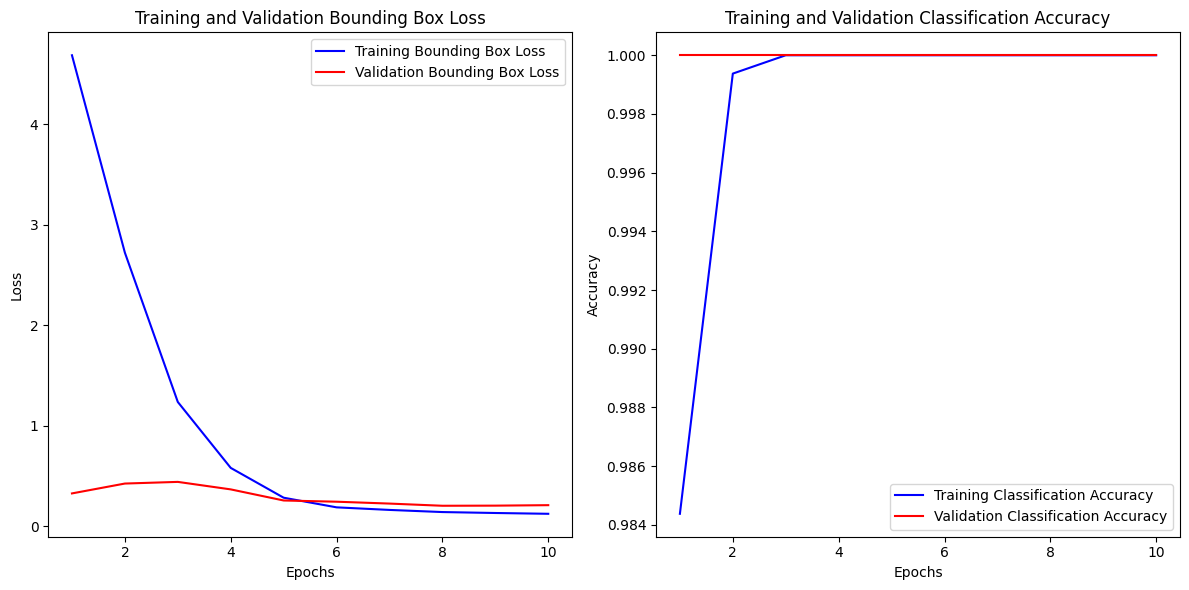

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
def plot_training_history(history):
    # Retrieve loss and accuracy values for both training and validation
    bbox_loss = history.history['dense_6_loss']
    val_bbox_loss = history.history['val_dense_6_loss']
    class_accuracy = history.history['dense_7_accuracy']
    val_class_accuracy = history.history['val_dense_7_accuracy']

    # Epochs range
    epochs = range(1, len(bbox_loss) + 1)

    # Plot bounding box loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, bbox_loss, 'b', label='Training Bounding Box Loss')
    plt.plot(epochs, val_bbox_loss, 'r', label='Validation Bounding Box Loss')
    plt.title('Training and Validation Bounding Box Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot classification accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, class_accuracy, 'b', label='Training Classification Accuracy')
    plt.plot(epochs, val_class_accuracy, 'r', label='Validation Classification Accuracy')
    plt.title('Training and Validation Classification Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)


In [ ]:
import tensorflow as tf

# Convert the pruned model to TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Optional: Provide a representative dataset for better quantization accuracy
def representative_dataset_gen():
    for i in range(len(images)):
        # Get a single image from the training set and preprocess it
        img = images[i].reshape(1, 224, 224, 1).astype(np.float32)  # Adjust based on your input size
        yield [img]

# Assign the representative dataset
converter.representative_dataset = representative_dataset_gen

# Convert the model to TFLite format with quantization
tflite_quantized_model = converter.convert()

# Save the quantized model to a file
with open('yolo_fastest_quantized_model.tflite', 'wb') as f:
    f.write(tflite_quantized_model)

print("Quantized TFLite model saved as 'yolo_fastest_quantized_model.tflite'.")


In [19]:
import tensorflow as tf

# Convert the model to TensorFlow Lite format with integer-only quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable integer-only quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Force the use of integer quantization for all layers
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to use int8 (8-bit integers)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Optional: Provide a representative dataset
def representative_dataset_gen():
    for i in range(len(images)):
        img = images[i].reshape(1, 224, 224, 1).astype(np.float32)
        yield [img]

converter.representative_dataset = representative_dataset_gen

# Convert the model
tflite_int_quantized_model = converter.convert()

# Save the quantized model to a file
with open('yolo_fastest_int8_quantized_model.tflite', 'wb') as f:
    f.write(tflite_int_quantized_model)

print("Integer-quantized TFLite model saved as 'yolo_fastest_int8_quantized_model.tflite'.")


INFO:tensorflow:Assets written to: C:\Users\xxnab\AppData\Local\Temp\tmpzo6bedc7\assets


INFO:tensorflow:Assets written to: C:\Users\xxnab\AppData\Local\Temp\tmpzo6bedc7\assets


Saved artifact at 'C:\Users\xxnab\AppData\Local\Temp\tmpzo6bedc7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='keras_tensor_54')
Output Type:
  List[TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  2129784800272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134633894096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134633894480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134633893904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134633892752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134633894288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134633895248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134633896400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2134633896784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21346

c:\Users\xxnab\OneDrive\Documents\GitHub\FYP\.venv\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Integer-quantized TFLite model saved as 'yolo_fastest_int8_quantized_model.tflite'.


In [21]:
import os

# Check the size of the quantized model
model_size = os.path.getsize('yolo_fastest_int8_quantized_model.tflite') / (1024 * 1024)  # Size in MB
print(f"Quantized TFLite model size: {model_size:.2f} MB")

Quantized TFLite model size: 1.40 MB
